# Main Project Notebook

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
# Needed for training
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from torch.utils.data.dataset import Subset
# Models
from models_part1 import FinalClassifier , MNISTAutoencoder, CIFAR10Autoencoder
from models_part2 import MNISTClassifyingAutoencoder,CIFAR10ClassifyingAutoencoder
from models_part3 import NTXentLoss,MnistSimCLR,Cifar10SimCLR
from models_testing import  plot_accuracies,plot_losses,test_classifier,test_classifyingAutoEncoder
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNIST

## Preparing data

In [14]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [15]:
train_size = 50_000
val_size = 10_000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


batch_size = 64

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([9, 5, 6, 1, 8])


## 1.2.1

In [16]:
# Model initialization
model = MNISTAutoencoder(latent_dim=128).to(device)

train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-4)

Epoch [1/25], Time: 9.01s, Train Loss: 0.7090, Val Loss: 0.6874, LR: 0.000100
Epoch [2/25], Time: 8.92s, Train Loss: 0.6503, Val Loss: 0.5960, LR: 0.000100
Epoch [3/25], Time: 8.90s, Train Loss: 0.5923, Val Loss: 0.5794, LR: 0.000100
Epoch [4/25], Time: 8.89s, Train Loss: 0.5832, Val Loss: 0.5738, LR: 0.000100
Epoch [5/25], Time: 8.90s, Train Loss: 0.5794, Val Loss: 0.5711, LR: 0.000100
Epoch [6/25], Time: 9.03s, Train Loss: 0.5771, Val Loss: 0.5690, LR: 0.000100
Epoch [7/25], Time: 8.99s, Train Loss: 0.5756, Val Loss: 0.5676, LR: 0.000100
Epoch [8/25], Time: 9.01s, Train Loss: 0.5744, Val Loss: 0.5665, LR: 0.000100
Epoch [9/25], Time: 9.02s, Train Loss: 0.5735, Val Loss: 0.5656, LR: 0.000100
Epoch [10/25], Time: 9.20s, Train Loss: 0.5727, Val Loss: 0.5650, LR: 0.000025
Epoch [11/25], Time: 9.48s, Train Loss: 0.5720, Val Loss: 0.5644, LR: 0.000025
Epoch [12/25], Time: 10.67s, Train Loss: 0.5717, Val Loss: 0.5642, LR: 0.000025
Epoch [13/25], Time: 9.95s, Train Loss: 0.5716, Val Loss: 0.

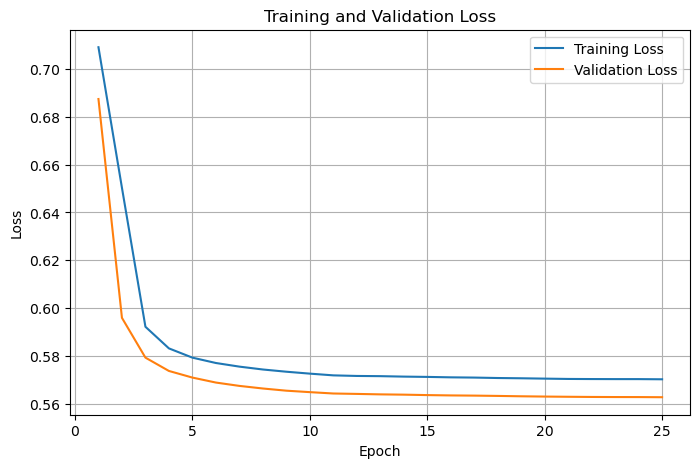

In [17]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [18]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 9.40s, Train Loss: 0.1826, Train Accuracy: 94.54%, Val Accuracy: 97.12%, LR: 0.001000
Epoch [2/15], Time: 9.22s, Train Loss: 0.0944, Train Accuracy: 97.05%, Val Accuracy: 97.31%, LR: 0.001000
Epoch [3/15], Time: 9.22s, Train Loss: 0.0729, Train Accuracy: 97.61%, Val Accuracy: 97.64%, LR: 0.001000
Epoch [4/15], Time: 9.24s, Train Loss: 0.0607, Train Accuracy: 98.06%, Val Accuracy: 97.73%, LR: 0.001000
Epoch [5/15], Time: 9.21s, Train Loss: 0.0537, Train Accuracy: 98.26%, Val Accuracy: 97.96%, LR: 0.001000
Epoch [6/15], Time: 9.55s, Train Loss: 0.0454, Train Accuracy: 98.48%, Val Accuracy: 98.18%, LR: 0.001000
Epoch [7/15], Time: 9.55s, Train Loss: 0.0410, Train Accuracy: 98.63%, Val Accuracy: 98.04%, LR: 0.001000
Epoch [8/15], Time: 9.33s, Train Loss: 0.0383, Train Accuracy: 98.74%, Val Accuracy: 97.94%, LR: 0.001000
Epoch [9/15], Time: 9.44s, Train Loss: 0.0363, Train Accuracy: 98.74%, Val Accuracy: 98.21%, LR: 0.001000
Epoch [10/15], Time: 9.15s, Train Loss: 0.0310

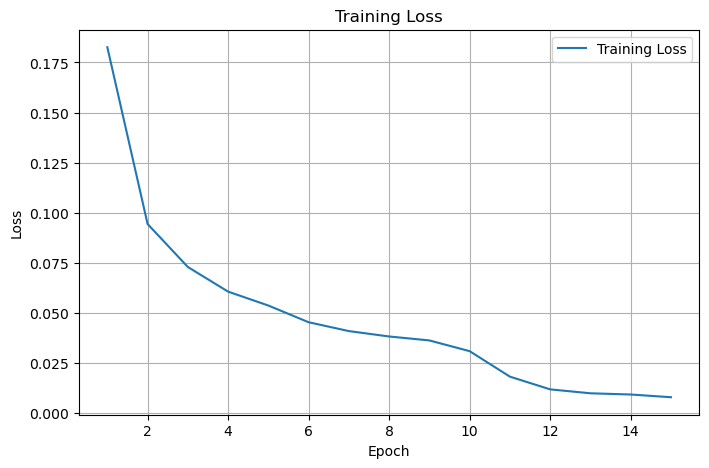

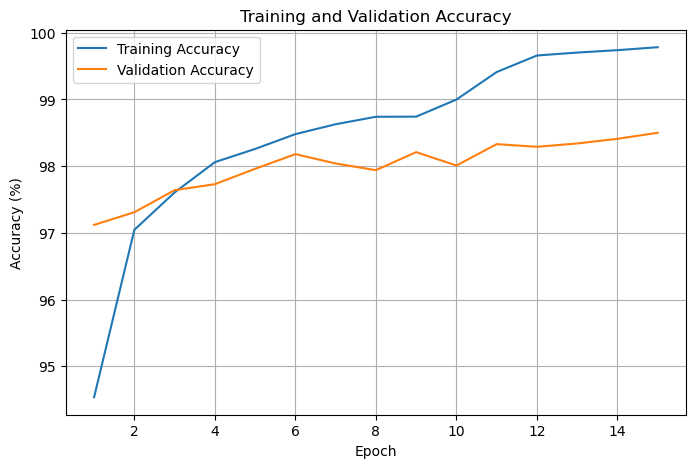

In [19]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [20]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 98.55%


## 1.2.2

In [11]:
# Model initialization
model = MNISTClassifyingAutoencoder(latent_dim=128).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=15,
                       learning_rate=1e-4)

Epoch [1/15], Time: 10.17s, Train Loss: 0.3248, Train Accuracy: 91.08%, Val Accuracy: 96.77%, LR: 0.000100
Epoch [2/15], Time: 9.94s, Train Loss: 0.0965, Train Accuracy: 97.21%, Val Accuracy: 97.80%, LR: 0.000100
Epoch [3/15], Time: 9.78s, Train Loss: 0.0624, Train Accuracy: 98.12%, Val Accuracy: 98.05%, LR: 0.000100
Epoch [4/15], Time: 9.81s, Train Loss: 0.0447, Train Accuracy: 98.61%, Val Accuracy: 98.25%, LR: 0.000100
Epoch [5/15], Time: 9.91s, Train Loss: 0.0331, Train Accuracy: 98.95%, Val Accuracy: 98.30%, LR: 0.000100
Epoch [6/15], Time: 9.90s, Train Loss: 0.0266, Train Accuracy: 99.19%, Val Accuracy: 98.63%, LR: 0.000100
Epoch [7/15], Time: 10.18s, Train Loss: 0.0203, Train Accuracy: 99.39%, Val Accuracy: 98.57%, LR: 0.000100
Epoch [8/15], Time: 9.76s, Train Loss: 0.0171, Train Accuracy: 99.48%, Val Accuracy: 98.50%, LR: 0.000100
Epoch [9/15], Time: 9.84s, Train Loss: 0.0141, Train Accuracy: 99.54%, Val Accuracy: 98.60%, LR: 0.000100
Epoch [10/15], Time: 9.87s, Train Loss: 0.01

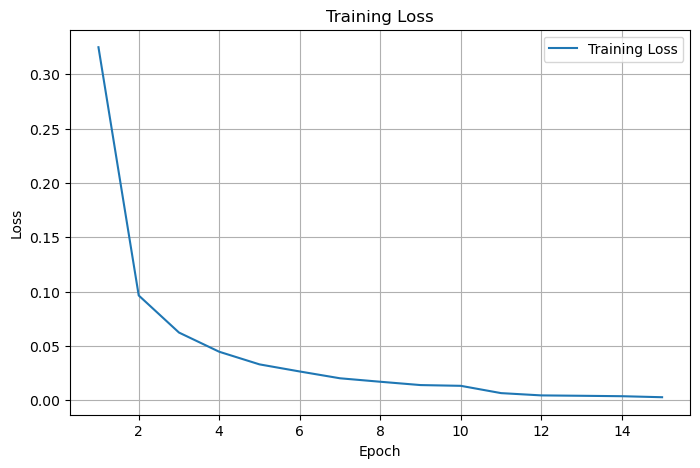

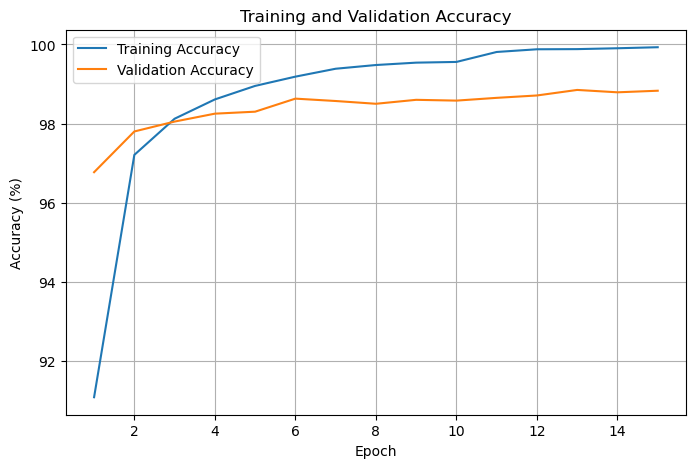

In [12]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [13]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=mnist_test_loader)

Test Accuracy: 98.71%


## 1.2.3

## Data preparation

In [3]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [4]:
train_size = 50_000
val_size = 10_000
batch_size = 2048


train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([512, 1, 28, 28]), Labels: tensor([2, 2, 7, 1, 1])


In [5]:
model = MnistSimCLR(latent_dim=128,dropout_prob=0.2,temperature = 0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-4)


Epoch [1/25], Time: 17.11s, Train Loss: 5.7567, Val Loss: 4.5097, LR: 0.000100
Epoch [2/25], Time: 8.35s, Train Loss: 4.6178, Val Loss: 4.2227, LR: 0.000100
Epoch [3/25], Time: 8.25s, Train Loss: 4.0988, Val Loss: 3.5534, LR: 0.000100
Epoch [4/25], Time: 8.25s, Train Loss: 3.9132, Val Loss: 3.4093, LR: 0.000100
Epoch [5/25], Time: 8.31s, Train Loss: 3.5158, Val Loss: 2.9791, LR: 0.000100
Epoch [6/25], Time: 9.36s, Train Loss: 3.3969, Val Loss: 2.8047, LR: 0.000100
Epoch [7/25], Time: 8.15s, Train Loss: 3.2959, Val Loss: 2.9454, LR: 0.000100
Epoch [8/25], Time: 8.25s, Train Loss: 3.1926, Val Loss: 2.8144, LR: 0.000100
Epoch [9/25], Time: 8.31s, Train Loss: 3.0943, Val Loss: 2.6049, LR: 0.000100
Epoch [10/25], Time: 8.23s, Train Loss: 2.9941, Val Loss: 2.6056, LR: 0.000010
Epoch [11/25], Time: 8.22s, Train Loss: 2.8595, Val Loss: 2.5259, LR: 0.000010
Epoch [12/25], Time: 8.30s, Train Loss: 2.8933, Val Loss: 2.5142, LR: 0.000010
Epoch [13/25], Time: 8.31s, Train Loss: 2.7999, Val Loss: 2.

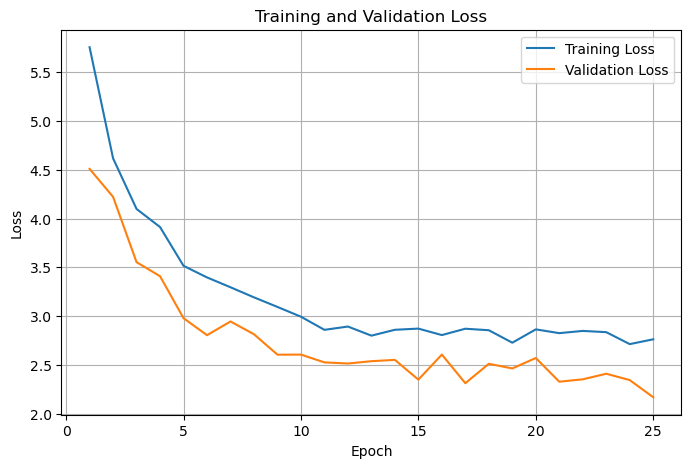

In [6]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [7]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader = mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 10.25s, Train Loss: 0.2704, Train Accuracy: 92.13%, Val Accuracy: 95.22%, LR: 0.001000
Epoch [2/15], Time: 10.39s, Train Loss: 0.1259, Train Accuracy: 96.02%, Val Accuracy: 95.72%, LR: 0.001000
Epoch [3/15], Time: 10.32s, Train Loss: 0.1035, Train Accuracy: 96.60%, Val Accuracy: 96.05%, LR: 0.001000
Epoch [4/15], Time: 10.18s, Train Loss: 0.0872, Train Accuracy: 97.17%, Val Accuracy: 96.23%, LR: 0.001000
Epoch [5/15], Time: 10.07s, Train Loss: 0.0760, Train Accuracy: 97.49%, Val Accuracy: 96.25%, LR: 0.001000
Epoch [6/15], Time: 10.10s, Train Loss: 0.0652, Train Accuracy: 97.85%, Val Accuracy: 96.39%, LR: 0.001000
Epoch [7/15], Time: 10.14s, Train Loss: 0.0577, Train Accuracy: 98.04%, Val Accuracy: 96.57%, LR: 0.001000
Epoch [8/15], Time: 10.01s, Train Loss: 0.0500, Train Accuracy: 98.34%, Val Accuracy: 96.52%, LR: 0.001000
Epoch [9/15], Time: 10.16s, Train Loss: 0.0443, Train Accuracy: 98.45%, Val Accuracy: 96.58%, LR: 0.001000
Epoch [10/15], Time: 10.18s, Train Lo

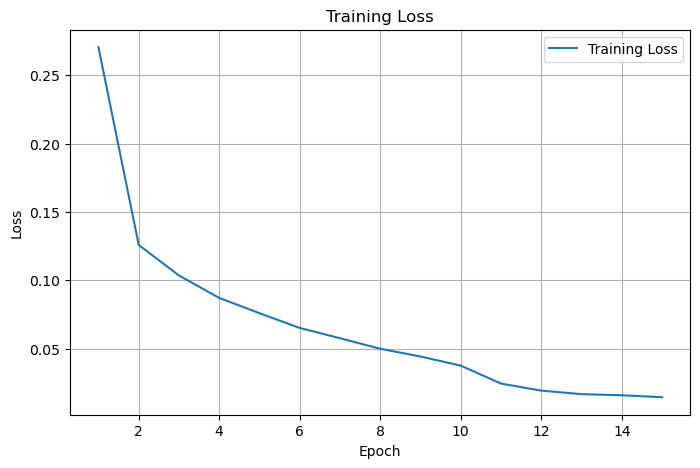

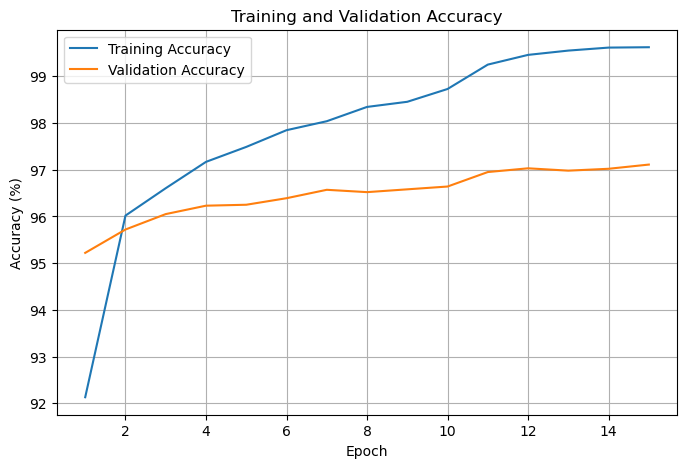

In [8]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [9]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 96.67%


# Cifar10

## Preparing data

In [3]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # CIFAR-10 has 3 channels (RGB)
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [4]:
train_size = 40_000
val_size = 10_000

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")

# Define batch size
batch_size = 64

# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 3, 32, 32]), Labels (first 5): tensor([3, 6, 1, 0, 6])


## 1.2.1

In [5]:
model = CIFAR10Autoencoder(latent_dim=128, dropout_prob = 0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate= 1e-3,
                        weight_decay= 1e-3)

Epoch [1/20], Time: 29.94s, Train Loss: 0.2174, Val Loss: 0.1505 , LR: 0.001000
Epoch [2/20], Time: 25.57s, Train Loss: 0.1541, Val Loss: 0.1385 , LR: 0.001000
Epoch [3/20], Time: 25.65s, Train Loss: 0.1469, Val Loss: 0.1278 , LR: 0.001000
Epoch [4/20], Time: 24.94s, Train Loss: 0.1367, Val Loss: 0.1184 , LR: 0.001000
Epoch [5/20], Time: 24.81s, Train Loss: 0.1310, Val Loss: 0.1163 , LR: 0.001000
Epoch [6/20], Time: 24.62s, Train Loss: 0.1274, Val Loss: 0.1145 , LR: 0.001000
Epoch [7/20], Time: 24.57s, Train Loss: 0.1236, Val Loss: 0.1095 , LR: 0.001000
Epoch [8/20], Time: 24.77s, Train Loss: 0.1209, Val Loss: 0.1043 , LR: 0.001000
Epoch [9/20], Time: 24.98s, Train Loss: 0.1194, Val Loss: 0.1035 , LR: 0.001000
Epoch [10/20], Time: 24.84s, Train Loss: 0.1173, Val Loss: 0.1015 , LR: 0.000100
Epoch [11/20], Time: 24.77s, Train Loss: 0.1121, Val Loss: 0.0963 , LR: 0.000100
Epoch [12/20], Time: 24.79s, Train Loss: 0.1113, Val Loss: 0.0961 , LR: 0.000100
Epoch [13/20], Time: 25.02s, Train Lo

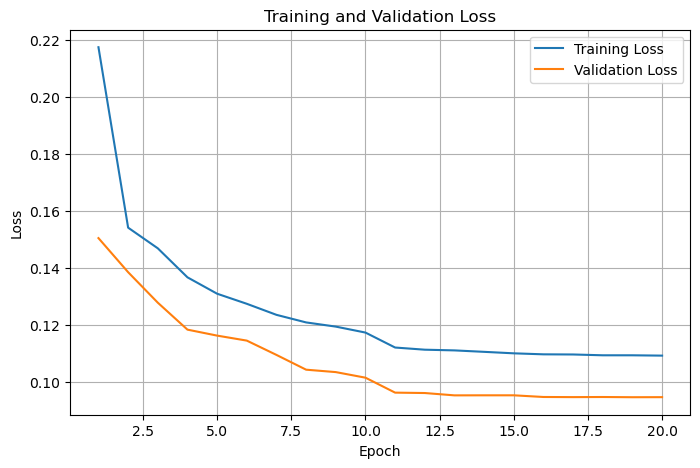

In [6]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [7]:
for param in model.encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
pretrained_encoder = model.encoder
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=20, learning_rate=1e-3)

Epoch [1/20], Time: 55.45s, Train Loss: 1.6933, Train Accuracy: 39.59%, Val Accuracy: 47.88%, LR: 0.001000
Epoch [2/20], Time: 54.28s, Train Loss: 1.4913, Train Accuracy: 47.09%, Val Accuracy: 49.88%, LR: 0.001000
Epoch [3/20], Time: 54.39s, Train Loss: 1.4136, Train Accuracy: 49.67%, Val Accuracy: 51.32%, LR: 0.001000
Epoch [4/20], Time: 53.57s, Train Loss: 1.3627, Train Accuracy: 51.37%, Val Accuracy: 53.04%, LR: 0.001000
Epoch [5/20], Time: 53.58s, Train Loss: 1.3243, Train Accuracy: 52.82%, Val Accuracy: 53.28%, LR: 0.001000
Epoch [6/20], Time: 53.53s, Train Loss: 1.2976, Train Accuracy: 53.63%, Val Accuracy: 54.07%, LR: 0.001000
Epoch [7/20], Time: 53.09s, Train Loss: 1.2680, Train Accuracy: 54.73%, Val Accuracy: 54.29%, LR: 0.001000
Epoch [8/20], Time: 53.88s, Train Loss: 1.2468, Train Accuracy: 55.33%, Val Accuracy: 54.42%, LR: 0.001000
Epoch [9/20], Time: 53.48s, Train Loss: 1.2242, Train Accuracy: 56.20%, Val Accuracy: 54.58%, LR: 0.001000
Epoch [10/20], Time: 53.72s, Train Lo

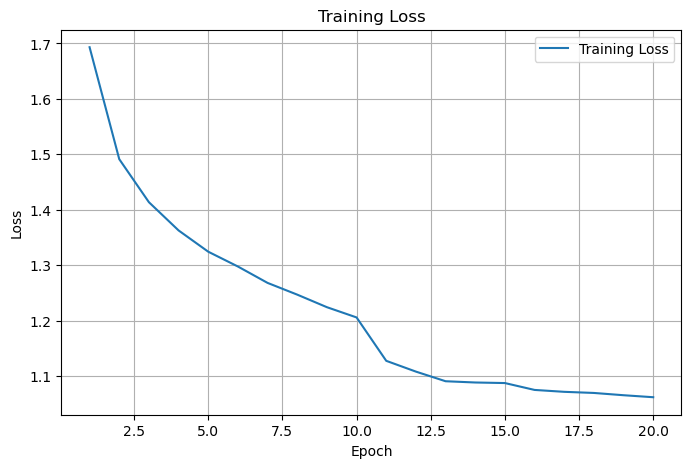

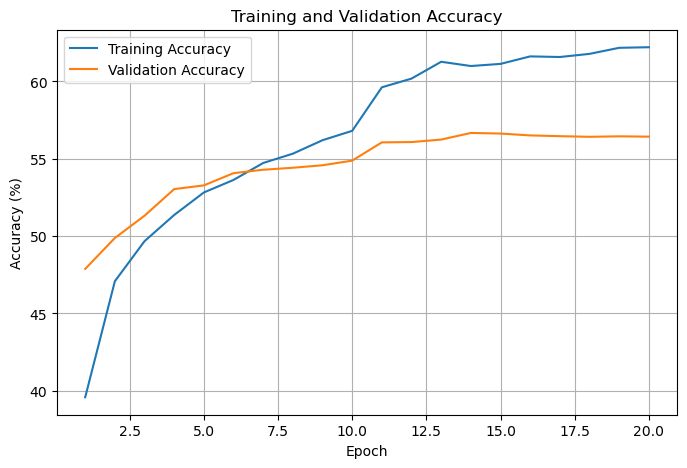

In [8]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [9]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

Test Accuracy: 56.26%


## 1.2.2

In [ ]:
# Model initialization
model = CIFAR10ClassifyingAutoencoder(latent_dim=128,resnet=True).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= c10_train_loader,
                                                                         val_loader=c10_val_loader,
                                                                         num_epochs=25,
                                                                         learning_rate=1e-4)

In [ ]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=c10_test_loader)

## 1.2.3

# Data Preparation

In [4]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # CIFAR-10 has 3 channels (RGB)
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [5]:
train_size = 40_000
val_size = 10_000
batch_size = 512

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")



# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([1024, 3, 32, 32]), Labels (first 5): tensor([9, 3, 6, 9, 6])


In [6]:
model = Cifar10SimCLR(latent_dim=128,dropout_prob=0.35,temperature=0.05,resnet=True).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate=1e-4)

C:\Users\Tomer\anaconda3\envs\cs236781-hw\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tomer\anaconda3\envs\cs236781-hw\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/20], Time: 366.37s, Train Loss: 2.7060, Val Loss: 1.4990, LR: 0.000100
Epoch [2/20], Time: 364.08s, Train Loss: 0.5052, Val Loss: 0.2900, LR: 0.000100
Epoch [3/20], Time: 354.93s, Train Loss: 0.3277, Val Loss: 0.2720, LR: 0.000100
Epoch [4/20], Time: 388.69s, Train Loss: 0.1539, Val Loss: 0.2938, LR: 0.000100
Epoch [5/20], Time: 383.29s, Train Loss: 0.1162, Val Loss: 0.0746, LR: 0.000100
Epoch [6/20], Time: 386.60s, Train Loss: 0.1225, Val Loss: 0.1578, LR: 0.000100
Epoch [7/20], Time: 385.54s, Train Loss: 0.1508, Val Loss: 0.0820, LR: 0.000100
Epoch [8/20], Time: 398.74s, Train Loss: 0.1348, Val Loss: 0.2796, LR: 0.000100
Epoch [9/20], Time: 406.81s, Train Loss: 0.0607, Val Loss: 0.0758, LR: 0.000100
Epoch [10/20], Time: 421.70s, Train Loss: 0.0582, Val Loss: 0.1553, LR: 0.000010
Epoch [11/20], Time: 384.45s, Train Loss: 0.0760, Val Loss: 0.0661, LR: 0.000010
Epoch [12/20], Time: 385.28s, Train Loss: 0.0763, Val Loss: 0.0991, LR: 0.000010
Epoch [13/20], Time: 409.06s, Train L

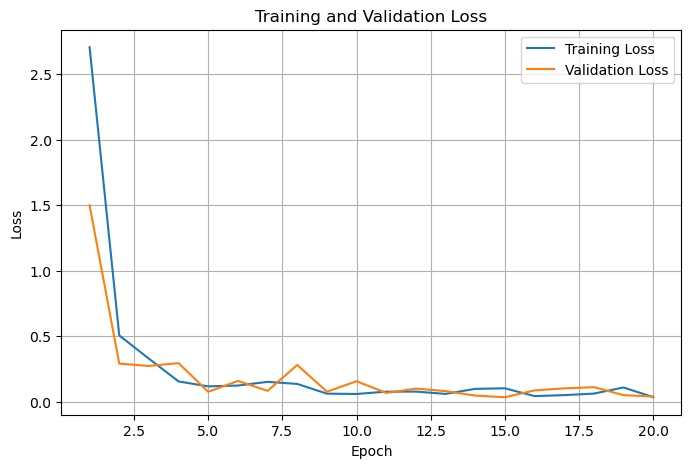

In [7]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [8]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=20, learning_rate=1e-3)

Epoch [1/20], Time: 73.40s, Train Loss: 1.6848, Train Accuracy: 39.74%, Val Accuracy: 44.65%, LR: 0.001000
Epoch [2/20], Time: 74.15s, Train Loss: 1.4806, Train Accuracy: 46.77%, Val Accuracy: 46.90%, LR: 0.001000
Epoch [3/20], Time: 74.12s, Train Loss: 1.4184, Train Accuracy: 48.93%, Val Accuracy: 47.71%, LR: 0.001000
Epoch [4/20], Time: 74.39s, Train Loss: 1.3868, Train Accuracy: 50.38%, Val Accuracy: 48.39%, LR: 0.001000
Epoch [5/20], Time: 74.26s, Train Loss: 1.3523, Train Accuracy: 51.48%, Val Accuracy: 48.77%, LR: 0.001000
Epoch [6/20], Time: 74.56s, Train Loss: 1.3275, Train Accuracy: 52.15%, Val Accuracy: 49.31%, LR: 0.001000
Epoch [7/20], Time: 74.61s, Train Loss: 1.3017, Train Accuracy: 53.23%, Val Accuracy: 49.29%, LR: 0.001000
Epoch [8/20], Time: 74.11s, Train Loss: 1.2815, Train Accuracy: 54.16%, Val Accuracy: 50.54%, LR: 0.001000
Epoch [9/20], Time: 72.92s, Train Loss: 1.2570, Train Accuracy: 54.71%, Val Accuracy: 50.47%, LR: 0.001000
Epoch [10/20], Time: 73.07s, Train Lo

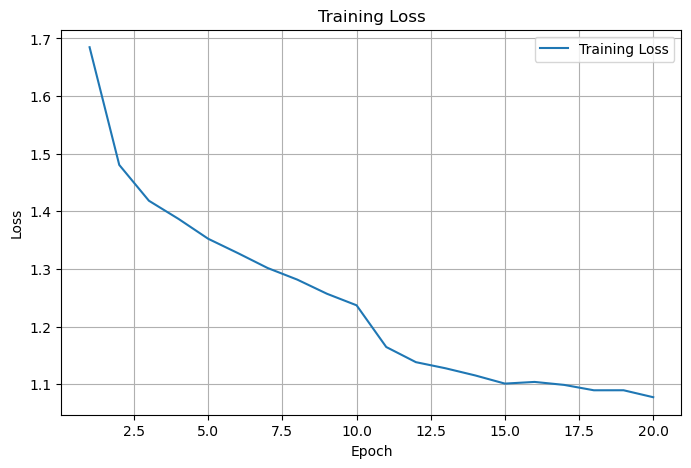

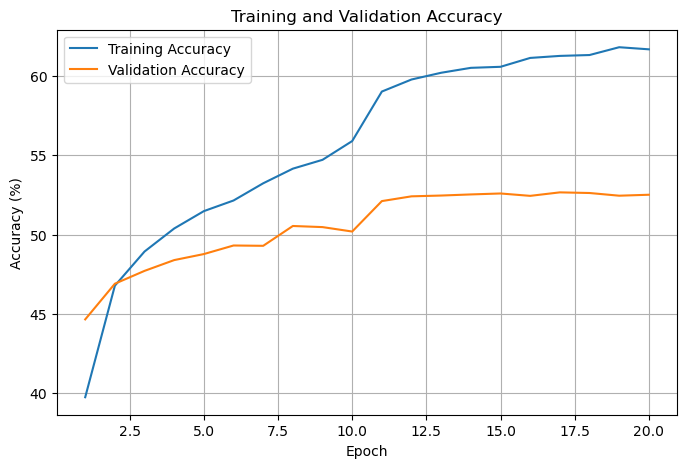

In [9]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [10]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

Test Accuracy: 52.16%
